For each dataset (2 HR, 2 SR, 4 SLO):

    - For each model (XLM-R-base, XLM-R-large, CSEBert, SloBERTa, BERTić, multiple versions of XLM-R-BERTić and XLM-R-SloBERTić):


        - fine-tune the model and evaluate it - 5 times

In [ ]:
from conllu import parse
import pandas as pd
import numpy as np
import json

# Loop through all the datasets if there are multiple datasets for one scenario
doc = "Janes-Tag.3.0.CoNLL-U/janes-tag.ud.conllu"

scenario = "ns_Slovene"

# Open the dataset
data = open("{}".format(doc), "r").read()

# Parse conllu file
sentences = parse(data)

word_list = []
sent_id_list = []
NER_list = []
split_list = []
doc_list = []

# Slovene corpora are not split into train, dev, test splits and have NER information under different keys than Croatian and Serbian
if "Slovene" in scenario:
	# Collect all important information from the dataset
	for sentence in sentences:
		current_sent_id = sentence.metadata["sent_id"]

	# Extract doc_ids and create a list of doc_ids
		if sentence.metadata.get("newdoc id", None) != None:
			current_doc_id = sentence.metadata["newdoc id"]
		# If sentence does not have a new doc id, use the one from the previous sentence that has it

		for token in sentence:
			current_word = token["form"]
			current_ner = token["misc"]["NER"]

			word_list.append(current_word)
			sent_id_list.append(current_sent_id)
			NER_list.append(current_ner)
			doc_list.append(current_doc_id)


	# Create a dictionary for all words and all needed information
	data_dict = {"sentence_id": sent_id_list, "words": word_list, "labels": NER_list, "doc_ids": doc_list}

	# Create a pandas df out of the dictionary
	df = pd.DataFrame(data_dict)

	LABELS = list(df.labels.unique())
	# If * is used, change * to O, because this causes errors
	if "*" in LABELS:
		LABELS[LABELS.index("*")] = "O"

		df["labels"] = np.where(df["labels"] == "*", "O", df["labels"])

	# Show the df
	print(df.head())
	print("\n")
	print(df.describe(include="all"))
	print("\n")
	print(df.labels.value_counts(normalize=True))
	print("\n")

ValueError: All arrays must be of the same length

In [ ]:
# Split the dataset based on doc ids in a 80:10:10 ratio
doc_ids = list(df["doc_ids"].unique())

# Shuffle the doc_ids randomly
random.shuffle(doc_ids)

# Calculate the number of doc_ids for each split
total_docs = len(doc_ids)
train_size = int(0.8 * total_docs)
test_size = int(0.1 * total_docs)
dev_size = total_docs - train_size - test_size

# Split the shuffled doc_ids into train, test, and dev sets
train_ids = doc_ids[:train_size]
test_ids = doc_ids[train_size:train_size + test_size]
dev_ids = doc_ids[train_size + test_size:]

## Setup and Dataset Importing

In [1]:
# Define the gpu on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

import evaluate
from datetime import datetime
import pandas as pd
import numpy as np
import json
from simpletransformers.ner import NERModel, NERArgs
from sklearn.metrics import classification_report, f1_score
from tqdm.autonotebook import tqdm as notebook_tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import logging
import sklearn
from numba import cuda
import argparse
import gc
import torch
import time

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [9]:
# Import the dataset

# Code for python script
"""
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("dataset", help="path to the dataset in JSON format")
    args = parser.parse_args()

# Define the path to the dataset
dataset_path = args.dataset
"""
# Define the path to the dataset
dataset_path = "datasets/hr500k.conllup_extracted.json"

# Load the json file
with open(dataset_path, "r") as file:
    json_dict = json.load(file)

# Open the train, eval and test dictionaries as DataFrames
train_df = pd.DataFrame(json_dict["train"])
test_df = pd.DataFrame(json_dict["test"])
dev_df = pd.DataFrame(json_dict["dev"])

# Change the sentence_ids to numbers
test_df['sentence_id'] = pd.factorize(test_df['sentence_id'])[0]
train_df['sentence_id'] = pd.factorize(train_df['sentence_id'])[0]
dev_df['sentence_id'] = pd.factorize(dev_df['sentence_id'])[0]

# Define the labels
LABELS = json_dict["labels"]
print(LABELS)

print(train_df.shape, test_df.shape, dev_df.shape)
print(train_df.head())



['O', 'B-loc', 'B-org', 'B-per', 'I-per', 'B-deriv-per', 'I-org', 'I-loc', 'B-misc', 'I-misc', 'I-deriv-per']
(398681, 3) (51190, 3) (49764, 3)
     sentence_id      words labels
717            0      Kazna      O
718            0  medijskom      O
719            0     mogulu      O
720            0   obnovila      O
721            0   raspravu      O


## Training code

In [15]:
def train_and_test(model, train_df, test_df, dataset_path):

    # Set up the model's arguments
    model_args = NERArgs()

    # Define the model

    # Define the model arguments - use the same one as for XLM-R-large if model is based on it,
    # if the model is of same size as XLM-R-base, use its optimal hyperparameters (I searched for them before)
    xlm_r_large_args = {"overwrite_output_dir": True,
                "num_train_epochs": 7,
                "labels_list": LABELS,
                "learning_rate": 1e-5,
                "train_batch_size": 32,
                # Comment out no_cache and no_save if you want to save the model
                "no_cache": True,
                "no_save": True,
                "max_seq_length": 256,
                "save_steps": -1,
                "silent": True,
                }

    xlm_r_base_args = {"overwrite_output_dir": True,
             "num_train_epochs": 8,
             "labels_list": LABELS,
             "learning_rate": 1e-5,
             "train_batch_size": 32,
             # Comment out no_cache and no_save if you want to save the model
             "no_cache": True,
             "no_save": True,
             "max_seq_length": 256,
             "save_steps": -1,
            "silent": True,
             }


    # Model type - a dictionary of type and model name.
    # To refer to our own models, use the path to the model directory as the model name.
    model_type_dict = {
        "sloberta": ["camembert", "EMBEDDIA/sloberta", xlm_r_base_args],
        "csebert": ["bert", "EMBEDDIA/crosloengual-bert", xlm_r_base_args],
        "xlm-r-base": ["xlmroberta", "xlm-roberta-base", xlm_r_base_args],
        "xlm-r-large": ["xlmroberta", "xlm-roberta-large", xlm_r_large_args],
        "bertic": ["electra", "classla/bcms-bertic", xlm_r_base_args],
        "xlmrl-bcms-48" : ["xlmroberta", "outputs/checkpoint-48000", xlm_r_large_args]
    }

    # Update the hyperparameters accordingly to the model
    model_args = model_type_dict[model][2]

    # Define the model
    current_model = NERModel(
    model_type_dict[model][0],
    model_type_dict[model][1],
    use_cuda=True,
    args = model_args)

    print("Training started. Current model: {}".format(model))
    print("Model arguments: epochs: {}, learning rate: {}, batch size: {}, max_seq_length: {}".format(model_args["num_train_epochs"], model_args["learning_rate"], model_args["train_batch_size"], model_args["max_seq_length"]))

    start_time = time.time()

    # Fine-tune the model
    current_model.train_model(train_df)

    print("Training completed.")

    training_time = round((time.time() - start_time)/60,2)

    print("It took {} minutes for {} instances.".format(training_time, train_df.shape[0]))

    # Clean cache
    gc.collect()
    torch.cuda.empty_cache()

    start_evaluation_time = time.time()

    # Evaluate the model
    results = current_model.eval_model(test_df)

    print("Evaluation completed.")

    evaluation_time = round((time.time() - start_evaluation_time)/60,2)

    print("It took {} minutes for {} instances.".format(evaluation_time, test_df.shape[0]))

    # Get predictions
    preds = results[1]

    # Create a list with predictions - my method
    preds_list = []

    for sentence in preds:
        for word in sentence:
            current_word = []
            for element in word:
                # Find prediction with the highest value
                highest_index = element.index(max(element))
                # Transform the index to label
                current_pred = current_model.config.id2label[highest_index]
                # Append to the list
                current_word.append(current_pred)
            # Segmentation can result in multiple predictions for one word - use the first prediction only
            preds_list.append(current_word[0])
    
    run_name = "{}-{}".format(dataset_path, model)

    y_true = test_df.labels.tolist()

    # Evaluate predictions
    metrics = evaluate.testing(y_true, preds_list, list(test_df.labels.unique()), run_name, show_matrix=True)

    # Add y_pred and y_true to the metrics dict
    metrics["y_true_T"] = y_true
    metrics["y_pred_T"] = preds_list

   # Calculate macro F1 with Nikola's/Rik's method as well
    preds_list_N = []

    # Use factorize to convert sentence_id to integer labels
    #test_df['sentence_id_f'] = pd.factorize(test_df['sentence_id'])[0]

    preds_N = results[2]
    kept_sentences = 0
    discarded_sentences = 0

    test_df["y_pred_N"] = ""

    # We unfold this list of lists, add it to original test data, and discard 
    # all of the sentences where there is a mismatch.
    for i in test_df.sentence_id.unique():
        subset = test_df[test_df.sentence_id == i]
        if subset.shape[0] == len(preds_N[i]):
            test_df.loc[test_df.sentence_id == i, "y_pred_N"] = preds_N[i]
            kept_sentences += 1
        else:
            discarded_sentences += 1
            continue

    test_df_N = test_df[test_df.y_pred_N != ""]
    y_true_N = test_df_N.labels.tolist()
    y_pred_N = test_df_N.y_pred_N.tolist()

    labels_N = list(test_df_N.labels.unique())

    print("Number of kept and discarded sentences; percentage of discarded sentences:")
    print(kept_sentences)
    print(discarded_sentences)
    print(discarded_sentences/(kept_sentences+discarded_sentences)*100)

    macrof1_N = f1_score(y_true_N, y_pred_N, labels=labels_N, average='macro')
    microf1_N = f1_score(y_true_N, y_pred_N, labels=labels_N, average='micro')
    clfreport = classification_report(y_true_N, y_pred_N, labels=labels_N)

    # Let's also add entire results
    metrics["results_output"] = results

    # Let's add Nikola's results
    metrics["Micro F1 Nikola"] = microf1_N
    metrics["Macro F1 Nikola"] = macrof1_N

    print("Nikola's Macro F1: {} and Micro F1: {}".format(macrof1_N, microf1_N))
    
    # The function returns a dict with accuracy, micro f1, macro f1, y_true and y_pred
    return metrics

In [8]:
# Create a new file for results
#with open("ner-results.txt", "w") as file:
#    file.write("Date\tModel\tRun\tDataset\tMicro F1\tMacro F1\tLabel Report\n")

In [16]:
# Testing the models if they work as expected
# models: ["xlm-r-large", "sloberta", "csebert", "xlm-r-base", "bertic"]
model = "xlmrl-bcms-48"
run = "test"

current_results_dict = train_and_test(model, train_df, test_df, dataset_path)

# Add to the dict model name, dataset name and run
current_results_dict["model"] = model
current_results_dict["run"] = "{}-{}".format(model, run)
current_results_dict["dataset"] = dataset_path

# Add to the file with results all important information
#with open("ner-results-testing.txt", "a") as file:
#    file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), current_results_dict["model"], current_results_dict["run"], current_results_dict["dataset"], current_results_dict["micro F1"], current_results_dict["macro F1"], current_results_dict["Micro F1 Nikola"], current_results_dict["Macro F1 Nikola"], current_results_dict["label-report"]))

# Add to the original test_df y_preds
#test_df["y_pred_{}_{}".format(model, run)] = current_results_dict["y_pred"]

# Save entire dict just in case
#with open("{}-{}-{}-backlog.json".format(dataset_path,model,run), "w") as backlog:
#    json.dump(current_results_dict, backlog, indent=2)

print("Run {} finished.".format(run))

# At the end, save the test_df with all predictions
#test_df.to_csv("{}-test_df-with-predictions.csv".format(dataset_path))

Some weights of the model checkpoint at outputs/checkpoint-48000 were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at outputs/checkpoint-48000 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task 

AttributeError: 'NERModel' object has no attribute 'parameters'

In [5]:
# Inspect results
results_df = pd.read_csv("ner-results-testing.txt", sep="\t")

results_df

,Date,Model,Run,Dataset,Micro F1,Macro F1,Micro F1 Nikola,Macro F1 Nikola,Label Report
0,17/08/2023 08:51:20,xlm-r-base,xlm-r-base-testing xlm-r-base,datasets/hr500k.conllup_extracted.json,0.839422,0.096976,0.864198,0.103069,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
1,17/08/2023 09:15:52,xlm-r-base,xlm-r-base-testing xlm-r-base,datasets/hr500k.conllup_extracted.json,0.839344,0.097316,0.863248,0.103009,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
2,17/08/2023 10:03:24,xlm-r-base,xlm-r-base-epochs-to-30,datasets/hr500k.conllup_extracted.json,0.839070,0.097772,0.867047,0.103251,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
3,17/08/2023 10:17:52,xlm-r-base,xlm-r-base-lr-to-1e-6,datasets/hr500k.conllup_extracted.json,0.839383,0.096620,0.861349,0.102992,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
4,17/08/2023 10:28:55,xlm-r-base,xlm-r-base-lr-to-1e-4,datasets/hr500k.conllup_extracted.json,0.839910,0.097347,0.870845,0.128229,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
5,17/08/2023 11:07:01,xlm-r-base,xlm-r-base-Nikola-default-args,datasets/hr500k.conllup_extracted.json,0.840496,0.098157,0.870309,0.103433,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."


## Run models

In [ ]:
#For each model, repeat training and testing 5 times - let's do 2 times for starters
model_list = ["xlm-r-large", "sloberta", "csebert", "xlm-r-base", "bertic"]

for model in model_list:
    for run in list(range(2)):
        current_results_dict = train_and_test(model, train_df, test_df, dataset_path)

        # Add to the dict model name, dataset name and run
        current_results_dict["model"] = model
        current_results_dict["run"] = "{}-{}".format(model, run)
        current_results_dict["dataset"] = dataset_path

        # Add to the file with results all important information
        with open("ner-results.txt", "a") as file:
            file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), current_results_dict["model"], current_results_dict["run"], current_results_dict["dataset"], current_results_dict["micro F1"], current_results_dict["macro F1"], current_results_dict["label-report"]))

        # Add to the original test_df y_preds
        test_df["y_pred_{}_{}".format(model, run)] = current_results_dict["y_pred"]

        # Save entire dict just in case
        with open("{}-{}-{}-backlog.json".format(dataset_path,model,run), "w") as backlog:
            json.dump(current_results_dict, backlog, indent=2)
    
        print("Run {} finished.".format(run))

# At the end, save the test_df with all predictions
test_df.to_csv("{}-test_df-with-predictions.csv".format(dataset_path))

In [ ]:
# Use factorize to convert sentence_id to integer labels
test_df['sentence_id'] = pd.factorize(test_df['sentence_id'])[0]

test_df.head(20)


In [ ]:
from sklearn.metrics import classification_report, f1_score

predictions = results[2]
kept_sentences = 0
discarded_sentences = 0

test_df["y_pred"] = ""

 # We unfold this list of lists, add it to original test data, and discard 
# all of the sentences where  there is a mismatch.
for i in test_df.sentence_id.unique():
    subset = test_df[test_df.sentence_id == i]
    if subset.shape[0] == len(predictions[i]):
        test_df.loc[test_df.sentence_id == i, "y_pred"] = predictions[i]
        kept_sentences += 1
    else:
        discarded_sentences += 1
        continue

test_df = test_df[test_df.y_pred != ""]
y_true = test_df.labels.tolist()
y_pred = test_df.y_pred.tolist()

labels = list(test_df.labels.unique())

print(len(y_true))
print(kept_sentences)
print(discarded_sentences)

#print(y_true,y_pred)
macrof1 = f1_score(y_true, y_pred, labels=labels, average='macro')
microf1 = f1_score(y_true, y_pred, labels=labels, average='micro')
clfreport = classification_report(y_true, y_pred, labels=labels)
print(str(microf1)+'\t'+str(macrof1))

In [ ]:
def train_and_test(model, train_df, test_df):

    # Set up the model's arguments
    model_args = NERArgs()

    # Define the model

    # Define the model arguments - use the same one as for XLM-R-large if model is based on it,
    # if the model is of same size as XLM-R-base, use its optimal hyperparameters (I searched for them before)
    xlm_r_large_args = {"overwrite_output_dir": True,
                "num_train_epochs": 7,
                "labels_list": LABELS,
                "learning_rate": 1e-5,
                "train_batch_size": 32,
                # Comment out no_cache and no_save if you want to save the model
                "no_cache": True,
                "no_save": True,
                "max_seq_length": 256,
                "save_steps": -1,
                "wandb_project": "NER",
                "silent": True,
                }

    xlm_r_base_args = {"overwrite_output_dir": True,
             "num_train_epochs": 8,
             "labels_list": LABELS,
             "learning_rate": 1e-5,
             "train_batch_size": 32,
             # Comment out no_cache and no_save if you want to save the model
             "no_cache": True,
             "no_save": True,
             "max_seq_length": 256,
             "save_steps": -1,
            "wandb_project": "NER",
            "silent": True,
             }


    # Model type - a dictionary of type and model name.
    # To refer to our own models, use the path to the model directory as the model name.
    model_type_dict = {
        "sloberta": ["camembert", "EMBEDDIA/sloberta", xlm_r_base_args],
        "csebert": ["bert", "EMBEDDIA/crosloengual-bert", xlm_r_base_args],
        "xlm-r-base": ["xlmroberta", "xlm-roberta-base", xlm_r_base_args],
        "xlm-r-large": ["xlmroberta", "xlm-roberta-large", xlm_r_large_args],
        "bertic": ["electra", "classla/bcms-bertic", xlm_r_base_args]
    }

    # Update the hyperparameters accordingly to the model
    model_args = model_type_dict[model][2]

    # Define the model
    current_model = NERModel(
    model_type_dict[model][0],
    model_type_dict[model][1],
    use_cuda=True,
    args = model_args)

    print("Training started. Current model: {}".format(model))
    start_time = time.time()

    # Fine-tune the model
    current_model.train_model(train_df)

    print("Training completed.")

    training_time = round((time.time() - start_time)/60,2)

    print("It took {} minutes for {} instances.".format(training_time, train_df.shape[0]))

    # Clean cache
    gc.collect()
    torch.cuda.empty_cache()

    start_evaluation_time = time.time()

    # Evaluate the model
    results = current_model.eval_model(test_df)

    print("Evaluation completed.")

    evaluation_time = round((time.time() - start_evaluation_time)/60,2)

    print("It took {} minutes for {} instances.".format(evaluation_time, test_df.shape[0]))

    # Get predictions
    preds = results[1]

    # Create a list with predictions
    preds_list = []

    for sentence in preds:
        for word in sentence:
            current_word = []
            for element in word:
                # Find prediction with the highest value
                highest_index = element.index(max(element))
                # Transform the index to label
                current_pred = current_model.config.id2label[highest_index]
                # Append to the list
                current_word.append(current_pred)
            # Segmentation can result in multiple predictions for one word - use the first prediction only
            preds_list.append(current_word[0])
    
    # Get y_true
    y_true = list(test_df.labels)

    # Evaluate predictions
    metrics = evaluate.testing(y_true, preds_list, list(test_df.labels.unique()), show_matrix=True)

    # Add y_pred and y_true to the metrics dict
    metrics["y_true"] = y_true
    metrics["y_pred"] = preds_list
    
    # The function returns a dict with accuracy, micro f1, macro f1, y_true and y_pred
    return metrics

In [ ]:
# Create a file with results
with open("ner-results.txt", "w") as file:
    file.write("Date\tModel\tRun\tDataset\tMicro F1\tMacro F1\tLabel Report\n")

In [ ]:
# For each model, repeat training and testing 5 times
model_list = ["xlm-r-large"]

for model in model_list:
    for run in list(range(5)):
        current_results_dict = train_and_test(model, train_df, test_df)

        # Add to the dict model name, dataset name and run
        current_results_dict["model"] = model
        current_results_dict["run"] = "{}-{}".format(model, run)
        current_results_dict["dataset"] = dataset_path

        # Add to the file with results all important information
        with open("ner-results.txt", "a") as file:
            file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), current_results_dict["model"], current_results_dict["run"], current_results_dict["dataset"], current_results_dict["micro F1"], current_results_dict["macro F1"], current_results_dict["label-report"]))

        # Add to the original test_df y_preds
        test_df["y_pred_{}_{}".format(model, run)] = current_results_dict["y_pred"]

        # Save entire dict just in case
        with open("{}-{}-{}-backlog.json".format(dataset_path,model,run), "w") as backlog:
            json.dump(current_results_dict, backlog, indent=2)
    
        print("Run {} finished.".format(run))

# At the end, save the test_df with all predictions
test_df.to_csv("{}-test_df-with-predictions.csv".format(dataset_path))

# Result Analysis

In [2]:
# Import the txt with results
import pandas as pd

results = pd.read_csv("ner-results.txt", sep="\t")

results

,Date,Model,Run,Dataset,Micro F1,Macro F1,Label Report
0,18/08/2023 16:39:46,xlm-r-large,xlm-r-large-0,datasets/hr500k.conllup_extracted.json,0.990291,0.918266,{'B-deriv-per': {'precision': 0.92105263157894...
1,18/08/2023 16:54:08,xlm-r-large,xlm-r-large-1,datasets/hr500k.conllup_extracted.json,0.990350,0.920143,{'B-deriv-per': {'precision': 0.92307692307692...
2,18/08/2023 17:02:56,sloberta,sloberta-0,datasets/hr500k.conllup_extracted.json,0.986618,0.889416,{'B-deriv-per': {'precision': 0.91666666666666...
3,18/08/2023 17:11:46,sloberta,sloberta-1,datasets/hr500k.conllup_extracted.json,0.985681,0.884556,{'B-deriv-per': {'precision': 0.91666666666666...
4,18/08/2023 17:20:49,csebert,csebert-0,datasets/hr500k.conllup_extracted.json,0.989861,0.913822,{'B-deriv-per': {'precision': 0.94444444444444...
5,18/08/2023 17:29:55,csebert,csebert-1,datasets/hr500k.conllup_extracted.json,0.990174,0.912708,{'B-deriv-per': {'precision': 0.91666666666666...
6,18/08/2023 17:40:13,xlm-r-base,xlm-r-base-0,datasets/hr500k.conllup_extracted.json,0.988611,0.909217,"{'B-deriv-per': {'precision': 1.0, 'recall': 0..."
7,18/08/2023 17:50:32,xlm-r-base,xlm-r-base-1,datasets/hr500k.conllup_extracted.json,0.988572,0.903684,{'B-deriv-per': {'precision': 0.91891891891891...
8,18/08/2023 17:59:35,bertic,bertic-0,datasets/hr500k.conllup_extracted.json,0.989744,0.918056,"{'B-deriv-per': {'precision': 1.0, 'recall': 0..."
9,18/08/2023 18:08:33,bertic,bertic-1,datasets/hr500k.conllup_extracted.json,0.989822,0.918230,{'B-deriv-per': {'precision': 0.97222222222222...


In [4]:
results.Dataset.unique()

array(['datasets/hr500k.conllup_extracted.json',
       'datasets/reldi-normtagner-hr.conllup_extracted.json',
       'datasets/reldi-normtagner-sr.conllup_extracted.json'],
      dtype=object)

<Axes: xlabel='Model'>

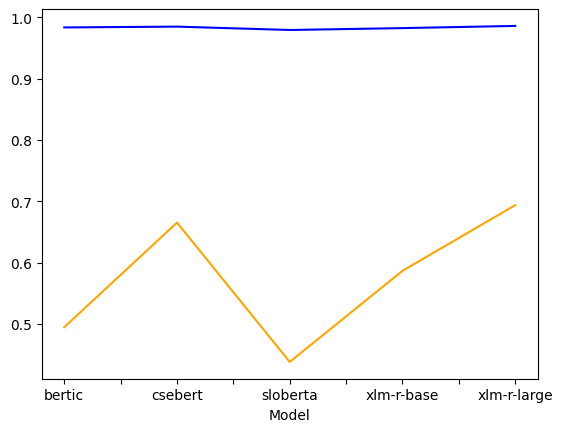

In [5]:
# Get average micro and macro F1
dataset = "datasets/reldi-normtagner-sr.conllup_extracted.json"

# Define the dataset to inspect
import matplotlib as plt
results[results["Dataset"] == dataset].groupby("Model")["Micro F1"].mean().plot(kind="line", color="blue")
results[results["Dataset"] == dataset].groupby("Model")["Macro F1"].mean().plot(kind="line",color="orange")

In [6]:
results[results["Dataset"] == dataset].groupby("Model")["Macro F1"].mean().round(2)

results["Macro F1"] = results["Macro F1"].round(2)

# Pivot the DataFrame to rearrange columns into rows
pivot_df = results.pivot(index='Run', columns='Dataset', values='Macro F1')

# Rename the columns
pivot_df.columns = list(results.Dataset.unique())

# Reset the index to have 'Model' as a column
pivot_df.reset_index(inplace=True)

pivot_df

,Run,datasets/hr500k.conllup_extracted.json,datasets/reldi-normtagner-hr.conllup_extracted.json,datasets/reldi-normtagner-sr.conllup_extracted.json
0,bertic-0,0.92,0.62,0.51
1,bertic-1,0.92,0.62,0.48
2,csebert-0,0.91,0.79,0.67
3,csebert-1,0.91,0.79,0.66
4,sloberta-0,0.89,0.50,0.44
5,sloberta-1,0.88,0.55,0.44
6,xlm-r-base-0,0.91,0.72,0.57
7,xlm-r-base-1,0.90,0.70,0.61
8,xlm-r-large-0,0.92,0.73,0.72
9,xlm-r-large-1,0.92,0.75,0.67


In [5]:
# Let's analyze the df with all the predictions
import numpy as np

pred_df = pd.read_csv("datasets/hr500k.conllup_extracted.json-test_df-with-predictions.csv", index_col = 0)

# Analyze instances where models are wrong
pred_df["match"] = np.where(pred_df["labels"] != pred_df["y_pred_xlm-r-large_0"], "no", "yes")
pred_df.match.value_counts()

match
yes    50693
no       497
Name: count, dtype: int64

In [8]:
pred_df[pred_df["match"] == "no"]

,sentence_id,words,labels,y_pred_xlm-r-large_0,y_pred_xlm-r-large_1,y_pred_sloberta_0,y_pred_sloberta_1,y_pred_csebert_0,y_pred_csebert_1,y_pred_xlm-r-base_0,y_pred_xlm-r-base_1,y_pred_bertic_0,y_pred_bertic_1,match
9433,30,11.,O,B-misc,O,O,O,O,O,O,O,O,O,no
9434,30,9.,O,I-misc,O,O,O,O,O,O,O,O,O,no
9454,30,rujna,O,I-misc,O,O,O,O,O,O,O,O,O,no
9769,42,11.,O,B-misc,O,O,O,O,O,O,O,O,O,no
9881,45,de,O,B-per,B-per,B-per,B-per,B-per,B-per,B-per,B-per,B-per,B-per,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491595,2452,Domu,O,B-org,B-org,B-org,B-org,O,O,B-org,B-org,O,O,no
491958,2472,2,O,B-misc,B-org,O,O,O,O,B-misc,B-misc,O,O,no
491959,2472,Mile,B-org,I-misc,I-org,O,O,B-misc,O,I-org,I-misc,B-misc,B-misc,no
491977,2473,Domu,O,B-org,B-org,B-org,B-org,B-org,B-org,B-org,B-org,B-org,O,no
